# Topological K-means

#### Importing libraries

In [229]:
import numpy as np # Linear algebra
import pandas as pd # Data processing
import matplotlib.pyplot as plt # Data visualization
import seaborn as sns # Data visualization
import networkx as nx # Graph analysis and manipulation

from numpy import dot
from numpy import trace
from numpy.linalg import inv
import scipy.sparse._csr
%matplotlib inline

import sklearn.datasets as skdata
import sklearn.neighbors as sknn
import sklearn.utils.graph as sksp
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import silhouette_score

import sys
import time
import warnings
warnings.simplefilter(action='ignore')

#### Importing dataset

In [230]:
### Scikit-learn datasets

X = skdata.load_iris()
#X = skdata.fetch_openml(name='segment', version=2)
#X = skdata.fetch_openml(name='amazon-commerce-reviews', version=1)
#X = skdata.fetch_openml(name='semeion', version=1)
#X = skdata.fetch_openml(name='mfeat-pixel', version=3)
#X = skdata.fetch_openml(name='AP_Colon_Kidney', version=1)
#X = skdata.fetch_openml(name='penguins', version=1)
#X = skdata.fetch_openml(name='cnae-9', version=2)
#X = skdata.fetch_openml(name='micro-mass', version=1)
#X = skdata.fetch_openml(name='oh5.wc', version=1)
#X = skdata.fetch_openml(name='tr45.wc', version=1)
#X = skdata.fetch_openml(name='GCM', version=1)
#X = skdata.fetch_openml(name='leukemia', version=1)
#X = skdata.fetch_openml(name='AP_Colon_Prostate', version=1)
#X = skdata.fetch_openml(name='AP_Breast_Lung', version=1)
#X = skdata.fetch_openml(name='cloud', version=2)
#X = skdata.fetch_openml(name='collins', version=2)
#X = skdata.fetch_openml(name='pyrim', version=2)
#X = skdata.fetch_openml(name='balance-scale', version=1)
#X = skdata.fetch_openml(name='servo', version=1)
#X = skdata.fetch_openml(name='monks-problems-1', version=1)
#X = skdata.fetch_openml(name='breast-tissue', version=1)
#X = skdata.fetch_openml(name='fri_c2_100_10', version=2)
#X = skdata.fetch_openml(name='datatrieve', version=1)
#X = skdata.fetch_openml(name='fri_c3_250_25', version=2)

### Slow
#X = skdata.load_digits()
#X = skdata.fetch_openml(name='phoneme', version=1)
#X = skdata.fetch_openml(name='Bioresponse', version=1)
#X = skdata.fetch_openml(name='optdigits', version=1)
#X = skdata.fetch_openml(name='satimage', version=1)

y = X['target']
X = X['data']
k = len(np.unique(y)) # Number of unique labels
n, m = X.shape # Number of observations and variables

if type(X) == scipy.sparse._csr.csr_matrix:
    X = X.todense()
    X = np.asarray(X)
else:
    if not isinstance(X, np.ndarray):
        cat_cols = X.select_dtypes(['category']).columns
        X[cat_cols] = X[cat_cols].apply(lambda x: x.cat.codes)
        X = X.to_numpy()
        y = y.to_numpy()

#### Exploratory Data Analysis

In [231]:
df = pd.DataFrame(data=X)
df.shape # (observations, variables)

(150, 4)

In [232]:
df.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Unique labels from the dataset

In [233]:
print(set(y))
print('Number of unique labels: {}'.format(len(set(y))))

{0, 1, 2}
Number of unique labels: 3


#### Converting labels into integers

In [234]:
labels = list(set(y))
numbers = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    numbers[i] = labels.index(y[i])

#### Geodesic K-means implementation

In [235]:
def centroid_distances(G,coord_centroids):
    distances = []
    for i in coord_centroids:
        D = nx.single_source_dijkstra(G,i)[0]
        temp = np.ones(n)*np.inf

        for j in D.keys():
            temp[j] = D[j]
        distances.append(temp)
    
    return np.array(distances)

def GeodesicKMeans(X):
    n_sqrt = round(np.sqrt(n))
    
    coord_centroids = np.random.choice(n, size=k, replace=False)
    centroids = X[coord_centroids] # Randomly chosen observations as centroids

    iteration = 0
    while iteration < 10:
        iteration += 1
        
        knnGraph = sknn.kneighbors_graph(X, n_neighbors=n_sqrt, mode='distance') # KNN graph
        W = knnGraph.toarray() # Adjacency matrix
        
        G = nx.from_numpy_array(W) # NetworkX graph
        distances = centroid_distances(G,coord_centroids) # Geodesic distances from each centroid to each observation

        geo_labels = np.zeros(n) # Array for labels
        for j in range(n):
            geo_labels[j] = distances[:, j].argmin() # Updating labels
        
        new_centroids = np.zeros((k, m))
        for r in range(k):
            indices = np.where(geo_labels==r)[0]
            
            if len(indices) > 0:
                sample = X[indices]
                new_centroids[r, :] = sample.mean(axis=0)
            else:
                new_centroids[r, :] = centroids[r, :]
        
        if (np.linalg.norm(centroids - new_centroids) < 0.1):
            break

        centroids = new_centroids.copy() # Updated centroids
    
    return geo_labels

#### Classical K-means

In [251]:
start_time = time.time()

MAX = 31
lista_rand = []
lista_sc = []
max_rand_labels = []

for i in range(1, MAX):
    kmeans = KMeans(n_clusters=k, init='random', n_init=1).fit(X)
    lista_rand.append(rand_score(y, kmeans.labels_))
    lista_sc.append(silhouette_score(X, kmeans.labels_))

    # Keeping track of the execution with maximum Rand index
    if i == 1:
        max_rand_labels = kmeans.labels_
    else:
        if rand_score(y, kmeans.labels_) > rand_score(y, max_rand_labels):
            max_rand_labels = kmeans.labels_

end_time = time.time()

print('Classical K-means')
print('Elapsed time: %.4f' %(end_time - start_time))
print()
print('Maximum Rand index: %.4f' %(max(lista_rand)))
print('Maximum Silhouette coefficient: %.4f' %(max(lista_sc)))

Classical K-means
Elapsed time: 0.1251

Maximum Rand index: 0.8797
Maximum Silhouette coefficient: 0.5528


#### Geodesic K-means

In [258]:
start_time = time.time()

MAX = 31
lista_rand = []
lista_sc = []
max_rand_labels_geo = []

for i in range(1, MAX):
    labels = GeodesicKMeans(X)
    lista_rand.append(rand_score(y, labels))
    lista_sc.append(silhouette_score(X, labels))

    # Keeping track of the execution with maximum Rand index
    if i == 1:
        max_rand_labels_geo = labels
    else:
        if rand_score(y, labels) > rand_score(y, max_rand_labels_geo):
            max_rand_labels_geo = labels

end_time = time.time()

print('Geodesic K-means')
print('Elapsed time: %.4f' %(end_time - start_time))
print()
print('Maximum Rand index: %.4f' %(max(lista_rand)))
print('Maximum Silhouette coefficient: %.4f' %(max(lista_sc)))

Geodesic K-means
Elapsed time: 0.2993

Maximum Rand index: 0.9740
Maximum Silhouette coefficient: 0.5432


#### Results

In [259]:
results = pd.DataFrame(data=X)
results['target'], results['Geodesic'], results['Classical'] = y, max_rand_labels_geo, max_rand_labels
results.head()

,0,1,2,3,target,Geodesic,Geodesic2,Classical
0,5.1,3.5,1.4,0.2,0,2.0,1.0,2
1,4.9,3.0,1.4,0.2,0,2.0,1.0,2
2,4.7,3.2,1.3,0.2,0,2.0,1.0,2
3,4.6,3.1,1.5,0.2,0,2.0,1.0,2
4,5.0,3.6,1.4,0.2,0,2.0,1.0,2


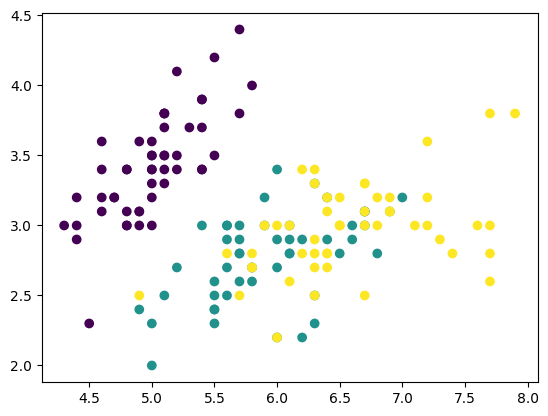

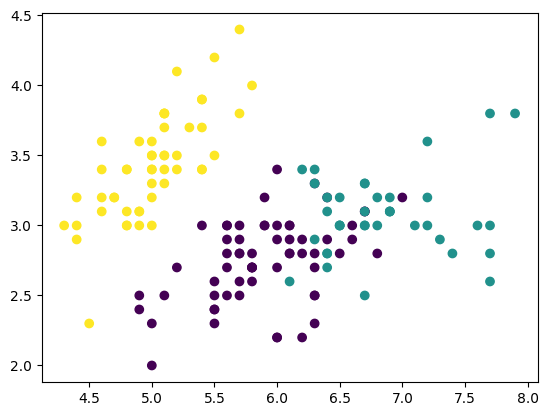

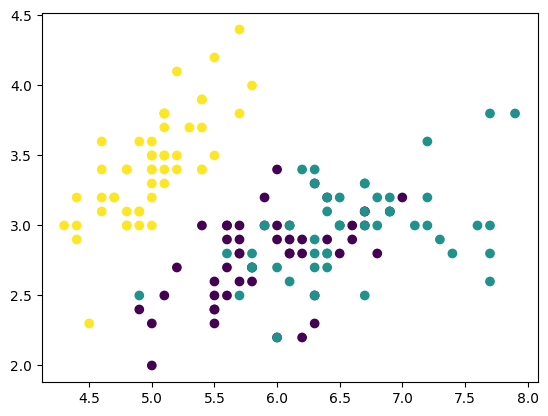

In [260]:
def iris_scatter(labels, df=skdata.load_iris()):
    _, ax = plt.subplots()
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels)

iris_scatter(y)
iris_scatter(max_rand_labels)
iris_scatter(max_rand_labels_geo)